In [ ]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 1.5 MB/s 


In [ ]:
# Standard modules
from time import sleep
import warnings
import numpy as np
import pandas as pd
warnings.filterwarnings('ignore')

# Graphical modules
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Preparation
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Workaround for skopt with sklearn==0.23.1
from numpy.ma import MaskedArray
import sklearn.utils.fixes
sklearn.utils.fixes.MaskedArray = MaskedArray

# Development
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as XGBoost
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Evaluation
from scipy import stats
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score

# Export
import joblib

In [ ]:
# Dataset
df = pd.read_csv('paper_dataset.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598 entries, 0 to 597
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   COVID-19 Exam result           598 non-null    int64  
 1   Patient admission              598 non-null    int64  
 2   Patient age quantile           598 non-null    int64  
 3   Basophils                      598 non-null    float64
 4   Eosinophils                    598 non-null    float64
 5   Hemoglobin                     598 non-null    float64
 6   Leukocytes                     598 non-null    float64
 7   Lymphocytes                    598 non-null    float64
 8   MCHC                           598 non-null    float64
 9   MCV                            598 non-null    float64
 10  MPV                            598 non-null    float64
 11  Monocytes                      598 non-null    float64
 12  Platelets                      598 non-null    flo

In [ ]:
# Define X and Y
features = ['Patient age quantile','Basophils', 'Eosinophils','Hemoglobin', 'Leukocytes', 'Lymphocytes','MCHC','MCV','MPV',
            'Monocytes', 'Platelets', 'RDW']
# Get X and Y
x = df[features]
y = df['Patient admission']

In [ ]:
# Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.15, random_state = 101, stratify=y)

In [ ]:
# % of target class in train set
pd.Series(y_train).value_counts()/len(y_train)

0    0.785433
1    0.094488
2    0.070866
3    0.049213
Name: Patient admission, dtype: float64

In [ ]:
# % of target class in test set
y_test.value_counts()/len(y_test)

0    0.788889
1    0.100000
2    0.066667
3    0.044444
Name: Patient admission, dtype: float64

In [ ]:
pd.Series(y_train).value_counts()

0    399
1     48
2     36
3     25
Name: Patient admission, dtype: int64

In [ ]:
# target class in test set
y_test.value_counts()

0    71
1     9
2     6
3     4
Name: Patient admission, dtype: int64

In [ ]:
# create SMOTE object
smt = SMOTE(random_state=1206)

# Do the process
x_train_smt, y_train_smt = smt.fit_resample(x_train, y_train)

In [ ]:
pd.Series(y_train_smt).value_counts()

0    399
1    399
3    399
2    399
Name: Patient admission, dtype: int64

In [ ]:
# Get copy of created samples
synth_samples_y = y_train_smt.copy()
# Create a new category for synth samples
synth_samples_y[len(y_train):] = 2
# Create a dataframe using oversampled data
df_synth = x_train_smt.copy()
df_synth['target'] = synth_samples_y
# Get slices for positive cases and synth positive cases
target_1 = df_synth[df_synth['target'] == 1]
target_2 = df_synth[df_synth['target'] == 2]

In [ ]:
num_features = ['Basophils', 'Basophils', 'Eosinophils','Hemoglobin', 'Leukocytes', 'Lymphocytes','MCHC','MCV','MPV',
                'Monocytes', 'Platelets', 'RDW']

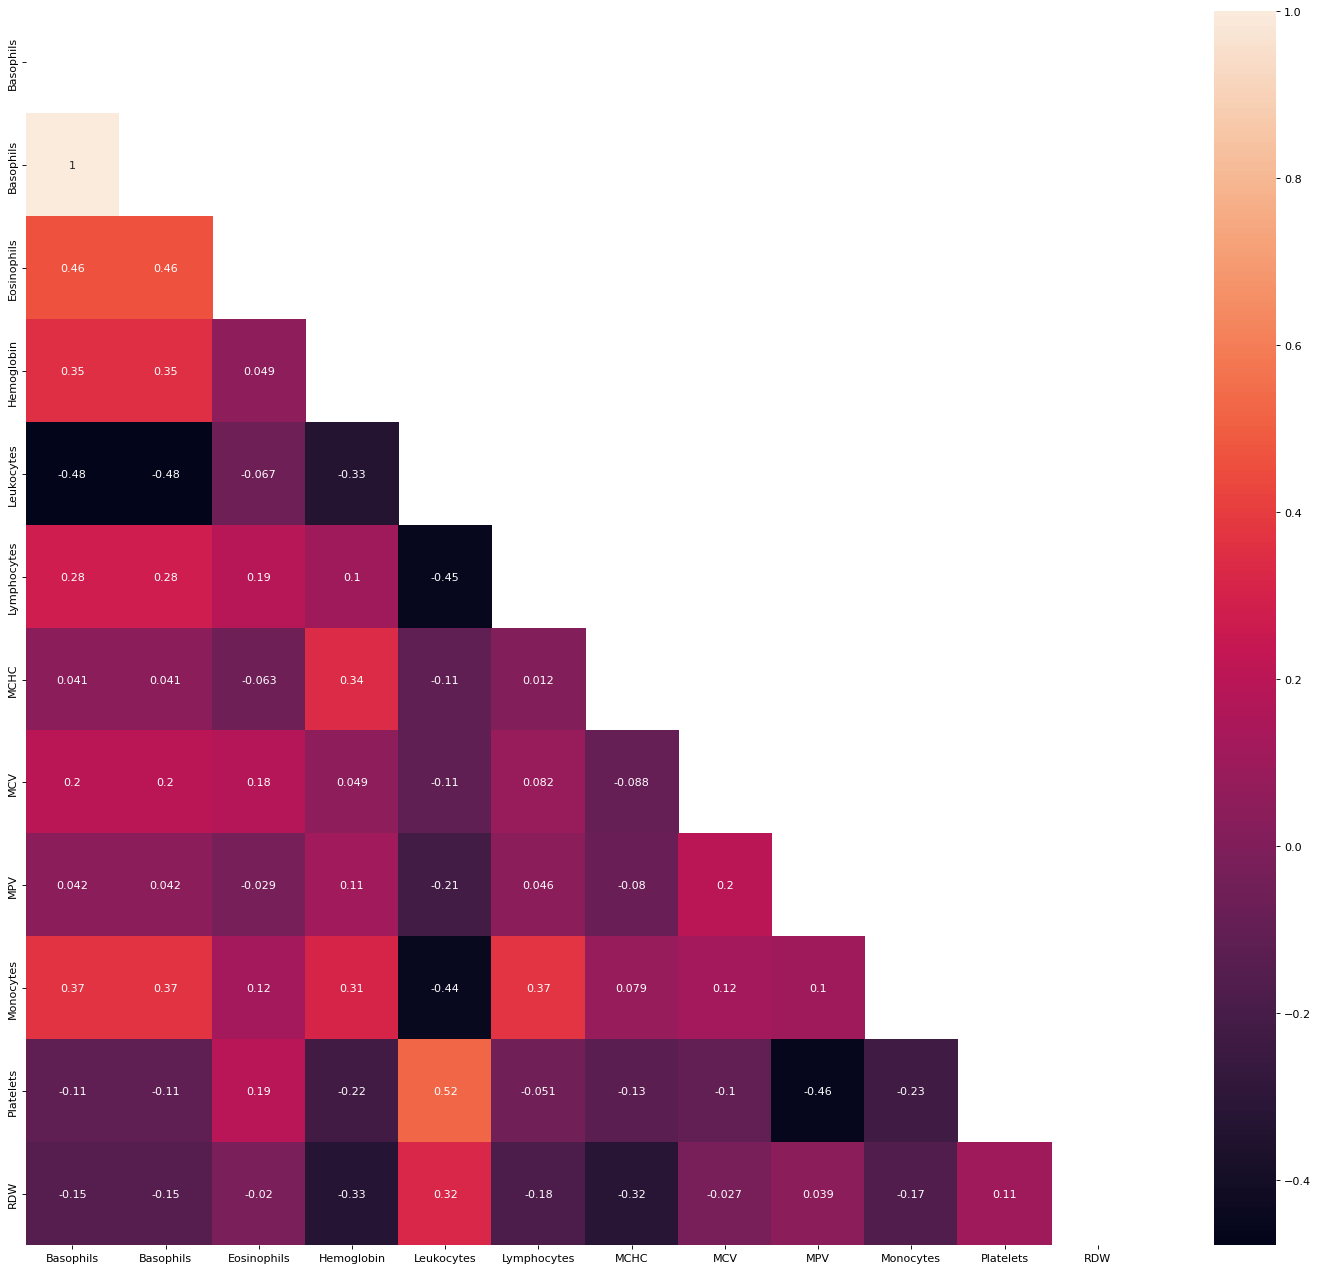

In [ ]:
# Correlation calculation
spearman_corr = df_synth[num_features].corr('spearman')
matrix = np.triu(spearman_corr)

# Plot
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(spearman_corr, annot = True, mask=matrix)
plt.tight_layout()

In [ ]:
# Define instance and fit in train set
mms = MinMaxScaler().fit(np.array(x_train['Patient age quantile']).reshape(-1, 1))

In [ ]:
# Apply transformation x train
x_train['Patient age quantile'] = mms.transform(np.array(x_train['Patient age quantile']).reshape(-1, 1)).round(6)
# Apply transformation x test
x_test['Patient age quantile'] = mms.transform(np.array(x_test['Patient age quantile']).reshape(-1, 1)).round(6)
# Apply transformation x train with SMOTE
x_train_smt['Patient age quantile'] = mms.transform(np.array(x_train_smt['Patient age quantile']).reshape(-1, 1)).round(6)
# Apply transformation df
df['Patient age quantile'] = mms.transform(np.array(df['Patient age quantile']).reshape(-1, 1)).round(6)

In [ ]:
x_train.head()

,Patient age quantile,Basophils,Eosinophils,Hemoglobin,Leukocytes,Lymphocytes,MCHC,MCV,MPV,Monocytes,Platelets,RDW
270,1.000000,0.081693,-0.751229,0.416252,0.673440,-1.617727,-1.149948,1.688438,2.927700,-1.113193,-1.158065,2.470904
116,0.789474,0.998070,1.018625,0.729532,0.097402,-1.191275,-0.353319,0.146163,-0.213711,-0.404086,-0.127997,1.497882
404,1.000000,-1.140144,1.271461,-0.335620,2.852366,-0.159261,-1.249524,0.927315,-0.325903,1.355549,2.999894,-0.801985
74,0.789474,0.692611,-0.498393,0.228284,-0.915534,-0.312784,0.642463,0.086074,-0.550290,2.852552,-0.668155,-0.359703
558,0.315789,-0.834685,-0.371974,-0.648900,0.350636,-1.063340,1.140354,0.626871,1.244801,-0.640455,-0.165682,-0.448160


**Auxiliar Functions**

In [ ]:
def printModelGeneralInfo(model, hp, score, metric_evaluated):
    print('#####################################################')
    print('Model:', type(model).__name__)
    print('Metric: ', metric_evaluated, ' | Score (%): ', 100*round(score,5))
    print('Best Parameters: ', hp)
    print('#####################################################\n')

In [ ]:
def optimizationGridCV(model_estimator, params, metric_to_eval, cv_generator, features, target):
    """
    Function to evaluate the best set of HP given a specific metric using Grid Search CV.
    
    Arguments:
        model_estimator: Model to be evaluated
        params: hyper parameters grid
        metric_to_eval: metric to be evaluated in the search (model evaluation)
        cv_generator: Stratified K-Fold Generator to guarantee reproductibility
        features: x train set to be used
        target: y train set to be used
    
    Returns:
        (best_model, best_hiperparameters, best_metric_score)
    """
    # Define Random Search CV object
    hp_search = GridSearchCV(estimator=model_estimator,param_grid=params,cv=cv_generator,
                             scoring=metric_to_eval,verbose=2,n_jobs=-1)
    # Search
    hp_search.fit(features, target)
    # Finish
    return (hp_search.best_estimator_, hp_search.best_params_, hp_search.best_score_, hp_search.cv_results_)

In [ ]:
def optimizationRandomCV(model_estimator, params, metric_to_eval, cv_generator, n_iter, features, target):
    """
    Function to evaluate the best set of HP given a specific metric using Random Search CV.
    
    Arguments:
        model_estimator: Model to be evaluated
        params: hyper parameters grid
        metric_to_eval: metric to be evaluated in the search (model evaluation)
        cv_generator: Stratified K-Fold Generator to guarantee reproductibility
        n_iter: iterations in RandomizedSearchCV
        features: x train set to be used
        target: y train set to be used
    
    Returns:
        (best_model, best_hiperparameters, best_metric_score)
    """
    # Define Random Search CV object
    hp_search = RandomizedSearchCV(estimator=model_estimator,
                                   param_distributions=params, 
                                   n_iter=n_iter,
                                   cv=cv_generator,
                                   scoring=metric_to_eval,
                                   verbose=2,
                                   random_state=101,
                                   n_jobs=-1)
    # Search
    hp_search.fit(features, target)
    # Finish
    return (hp_search.best_estimator_, hp_search.best_params_, hp_search.best_score_, hp_search.cv_results_)

In [ ]:
def optimizationBayesCV(model_estimator, params, metric_to_eval, cv_generator, n_iter, features, target):
    """
    Function to evaluate the best set of HP given a specific metric using Bayes Optimization Search CV.
    
    Arguments:
        model_estimator: Model to be evaluated
        params: hyper parameters grid
        metric_to_eval: metric to be evaluated in the search (model evaluation)
        cv_generator: Stratified K-Fold Generator to guarantee reproductibility
        n_iter: iterations in BayesSearchCV
        features: x train set to be used
        target: y train set to be used
    
    Returns:
        (best_model, best_hiperparameters, best_metric_score)
    """
    # Define Search CV object
    hp_search = BayesSearchCV(estimator=model_estimator,
                              search_spaces=params,
                              n_iter=n_iter,
                              cv=cv_generator,
                              scoring=metric_to_eval,
                              verbose=0,
                              random_state=101,
                              n_jobs=5,
                              n_points=5)
    # Search
    hp_search.fit(features, target)
    # Finish
    return (hp_search.best_estimator_, hp_search.best_params_, hp_search.best_score_, hp_search.cv_results_)

In [ ]:
def optimizationPipeline(estimator,params,x_train,y_train,metric_eval,cv_generator,opt_option='grid',n_iter=None):
    """
    Function to apply a specific HP optimization and present results.
    Arguments:
        estimator: Model to be evaluated
        params: hyper parameters grid
        x_train: self explanatory
        y_train: self explanatory
        metric_to_eval: metric to be evaluated in the search (model evaluation)
        opt_option: define the methodology to HP Optimization. Can be 'grid','random' or 'bayes'
        cv_generator: Stratified K-Fold Generator to guarantee reproductibility
        n_iter: iterations in RandomSearchCV or BayesOptimization. It's ignored if opt_option is 'grid'.
    Returns:
        dictionary with overall results
    """  
    # 1 - SEARCH
    if opt_option == 'grid':
        best_model,best_params,best_score,cv_results = optimizationGridCV(estimator,params,metric_eval,cv_generator,
                                                                          x_train,y_train)
    elif opt_option == 'random':
        best_model,best_params,best_score,cv_results = optimizationRandomCV(estimator,params,metric_eval,cv_generator,
                                                                            n_iter,x_train,y_train)
    elif opt_option == 'bayes':
        best_model,best_params,best_score,cv_results = optimizationBayesCV(estimator,params,metric_eval,cv_generator,
                                                                           n_iter,x_train,y_train)
    else:
        print('ERROR - Wrong opt_option selected')
        return
    
    # Wait for results
    sleep(1.5)    
    # 2 - Show Model Results
    printModelGeneralInfo(best_model, best_params, best_score, metric_eval)
    # 3 - Returns
    returned_dict = {'best_model':best_model,'best_params':best_params,'best_score':best_score,
                     'cv_res':pd.DataFrame(cv_results),'metric_used':metric_eval}
    return returned_dict

**Hyper parameters optimization**
Details:

    Metrics: f1 which represents F1-Score
    Models: Logistic Regression, SVM, Random Forest, Gradient Boosting and XGBoost
    Process to optimize: CV 5-Fold Strafied. Optimization algorithm is Bayes Optimization.


In [ ]:
# Metric used
metric_optimize = sklearn.metrics.make_scorer(sklearn.metrics.f1_score, average = 'macro')

In [ ]:
# Stratified K-Fold generator - Generate a general split to be able to compare all models with CV results
strat_cv_5folds = StratifiedKFold(n_splits=5,random_state=101, shuffle=True)

**HPO Procedure**

**logistic regression oversampled**

In [ ]:
## Define Estimator
estimator = LogisticRegression(random_state=1206,penalty='elasticnet', solver='saga', max_iter=5000 , multi_class='multinomial')
## Define Parameters
params = {'C': Real(1e-4, 10, prior='log-uniform'),
          'l1_ratio': Real(0, 1, prior='uniform'),
          'class_weight': Categorical(['balanced',None], transform='onehot')}

## HP Optimization
lre_res_ove = optimizationPipeline(estimator,params,x_train_smt,y_train_smt,metric_optimize, 
                                   strat_cv_5folds,opt_option='bayes',n_iter=100)

KeyboardInterrupt: ignored

**logistic regression imbalnced**

In [ ]:
## Define Estimator
estimator = LogisticRegression(random_state=1206,penalty='elasticnet', solver='saga', max_iter=5000 , multi_class='multinomial')
## Define Parameters
params = {'C': Real(1e-4, 10, prior='log-uniform'),
          'l1_ratio': Real(0, 1, prior='uniform'),
          'class_weight': Categorical(['balanced',None], transform='onehot')}

## HP Optimization
lre_res_bal = optimizationPipeline(estimator,params,x_train,y_train,metric_optimize, 
                                   strat_cv_5folds,opt_option='bayes',n_iter=100)

#####################################################
Model: LogisticRegression
Metric:  make_scorer(f1_score, average=macro)  | Score (%):  33.62
Best Parameters:  OrderedDict([('C', 0.000911256196596191), ('class_weight', 'balanced'), ('l1_ratio', 0.0)])
#####################################################



**SVM oversampled**

In [ ]:
## Define Estimator
estimator = SVC(random_state=1206, probability=True ,decision_function_shape='ovo')
## Define Parameters
params = {'C': Real(1e-4, 10, prior='log-uniform'),
          'shrinking': Categorical([True, False], transform='onehot'),
          'kernel': Categorical(['linear','rbf','poly','sigmoid'], transform='onehot'),
          'gamma': Categorical(['scale', 'auto'], transform='onehot'),
          'class_weight': Categorical(['balanced',None], transform='onehot')}

## HP Optimization
svm_res_ove = optimizationPipeline(estimator,params,x_train_smt,y_train_smt,metric_optimize,strat_cv_5folds,
                                   opt_option='bayes',n_iter=100)

#####################################################
Model: SVC
Metric:  make_scorer(f1_score, average=macro)  | Score (%):  94.772
Best Parameters:  OrderedDict([('C', 10.0), ('class_weight', None), ('gamma', 'scale'), ('kernel', 'rbf'), ('shrinking', True)])
#####################################################



**svm imbalanced**

In [ ]:
## Define Estimator
estimator = SVC(random_state=1206, probability=True ,decision_function_shape='ovo')
## Define Parameters
params = {'C': Real(1e-4, 10, prior='log-uniform'),
          'shrinking': Categorical([True, False], transform='onehot'),
          'kernel': Categorical(['linear','rbf','poly','sigmoid'], transform='onehot'),
          'gamma': Categorical(['scale', 'auto'], transform='onehot'),
          'class_weight': Categorical(['balanced',None], transform='onehot')}

## HP Optimization
svm_res_bal = optimizationPipeline(estimator,params,x_train,y_train,metric_optimize,strat_cv_5folds,
                                   opt_option='bayes',n_iter=100)

#####################################################
Model: SVC
Metric:  make_scorer(f1_score, average=macro)  | Score (%):  41.884
Best Parameters:  OrderedDict([('C', 0.5864007915956223), ('class_weight', 'balanced'), ('gamma', 'auto'), ('kernel', 'rbf'), ('shrinking', True)])
#####################################################



**random forest oversampled**

In [ ]:
## Define Estimator
estimator = RandomForestClassifier(random_state=1206, criterion='gini', warm_start=True)
## Define Parameters Grid
params = {'n_estimators': Integer(100, 1000, prior='uniform'),
          'max_depth': Integer(2, 32, prior='uniform'),
          'min_samples_split': Integer(2, 16, prior='uniform'),
          'min_samples_leaf': Integer(1, 8, prior='uniform'),
          'class_weight': Categorical(['balanced','balanced_subsample',None], transform='onehot'),
          'max_features': Categorical(['sqrt','log2'], transform='onehot')}
## HP Optimization
rfc_res_ove = optimizationPipeline(estimator,params,x_train_smt,y_train_smt,metric_optimize,strat_cv_5folds,
                                   opt_option='bayes',n_iter=100)

#####################################################
Model: RandomForestClassifier
Metric:  make_scorer(f1_score, average=macro)  | Score (%):  94.375
Best Parameters:  OrderedDict([('class_weight', 'balanced'), ('max_depth', 31), ('max_features', 'log2'), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 127)])
#####################################################



**random forest imbalnced**

In [ ]:
## Define Estimator
estimator = RandomForestClassifier(random_state=1206, criterion='gini', warm_start=True)
## Define Parameters Grid
params = {'n_estimators': Integer(100, 1000, prior='uniform'),
          'max_depth': Integer(2, 32, prior='uniform'),
          'min_samples_split': Integer(2, 16, prior='uniform'),
          'min_samples_leaf': Integer(1, 8, prior='uniform'),
          'class_weight': Categorical(['balanced','balanced_subsample',None], transform='onehot'),
          'max_features': Categorical(['sqrt','log2'], transform='onehot')}
## HP Optimization
rfc_res_bal = optimizationPipeline(estimator,params,x_train,y_train,metric_optimize,strat_cv_5folds,
                                   opt_option='bayes',n_iter=100)

#####################################################
Model: RandomForestClassifier
Metric:  make_scorer(f1_score, average=macro)  | Score (%):  38.127
Best Parameters:  OrderedDict([('class_weight', 'balanced_subsample'), ('max_depth', 25), ('max_features', 'sqrt'), ('min_samples_leaf', 8), ('min_samples_split', 2), ('n_estimators', 530)])
#####################################################



** gradiant boosting oversampled **

In [ ]:
## Define Estimator
estimator = GradientBoostingClassifier(random_state=1206, loss='deviance', criterion='friedman_mse', warm_start=True)
## Define Parameters
params = {'n_estimators': Integer(100, 1000, prior='uniform'),
          'min_samples_leaf': Integer(1, 8, prior='uniform'),
          'min_samples_split': Integer(2, 16, prior='uniform'),
          'max_depth': Integer(2, 32, prior='uniform'),
          'subsample': Real(0.75, 1, prior='uniform'),
          'learning_rate': Real(1e-5, 10, prior='log-uniform'),
          'max_features': Categorical(['sqrt','log2'], transform='onehot')}
## HP Optimization
bst_res_ove = optimizationPipeline(estimator,params,x_train_smt,y_train_smt,metric_optimize,strat_cv_5folds,
                                   opt_option='bayes',n_iter=100)

#####################################################
Model: GradientBoostingClassifier
Metric:  make_scorer(f1_score, average=macro)  | Score (%):  96.408
Best Parameters:  OrderedDict([('learning_rate', 0.16245020188575132), ('max_depth', 27), ('max_features', 'log2'), ('min_samples_leaf', 5), ('min_samples_split', 9), ('n_estimators', 1000), ('subsample', 0.8077757351279619)])
#####################################################



**gradiant boosting imbalanced**

In [ ]:
## Define Estimator
estimator = GradientBoostingClassifier(random_state=1206, loss='deviance', criterion='friedman_mse', warm_start=True)
## Define Parameters
params = {'n_estimators': Integer(100, 1000, prior='uniform'),
          'min_samples_leaf': Integer(1, 8, prior='uniform'),
          'min_samples_split': Integer(2, 16, prior='uniform'),
          'max_depth': Integer(2, 32, prior='uniform'),
          'subsample': Real(0.75, 1, prior='uniform'),
          'learning_rate': Real(1e-5, 10, prior='log-uniform'),
          'max_features': Categorical(['sqrt','log2'], transform='onehot')}
## HP Optimization
bst_res_bal = optimizationPipeline(estimator,params,x_train,y_train,metric_optimize,strat_cv_5folds,
                                   opt_option='bayes',n_iter=100)

#####################################################
Model: GradientBoostingClassifier
Metric:  make_scorer(f1_score, average=macro)  | Score (%):  38.714
Best Parameters:  OrderedDict([('learning_rate', 0.019672177242426186), ('max_depth', 26), ('max_features', 'log2'), ('min_samples_leaf', 3), ('min_samples_split', 13), ('n_estimators', 649), ('subsample', 0.75)])
#####################################################



### **XGBoost oversampled**

In [ ]:
## Define Estimator
estimator = XGBClassifier(objective='multi:softprob',random_state=1206,booster='gbtree', eval_metric='logloss')
## Define Parameters
params = {'n_estimators': Integer(100, 1000, prior='uniform'),
          'min_child_weight': Integer(1, 10, prior='uniform'),
          'max_depth': Integer(2, 32, prior='uniform'),
          'subsample': Real(0.75, 1, prior='uniform'),
          'colsample_bytree': Real(0.75, 1, prior='uniform'),
          'scale_pos_weight': Real(0.75, 1, prior='uniform'),
          'learning_rate': Real(1e-6, 10, prior='log-uniform'),
          'gamma': Real(1e-4, 10, prior='log-uniform'),
          'reg_alpha': Real(1e-3, 10, prior='log-uniform'),
          'reg_lambda': Real(1e-3, 10, prior='log-uniform')}
## HP Optimization
xgb_res_ove = optimizationPipeline(estimator,params,x_train_smt,y_train_smt,metric_optimize,strat_cv_5folds,
                                   opt_option='bayes',n_iter=100)

#####################################################
Model: XGBClassifier
Metric:  make_scorer(f1_score, average=macro)  | Score (%):  94.964
Best Parameters:  OrderedDict([('colsample_bytree', 0.8178829775651513), ('gamma', 0.0004213956190691541), ('learning_rate', 0.10296255463364322), ('max_depth', 9), ('min_child_weight', 1), ('n_estimators', 100), ('reg_alpha', 0.002363725776726323), ('reg_lambda', 0.001), ('scale_pos_weight', 0.8566758207057203), ('subsample', 0.7770091966476244)])
#####################################################



**xgboost imbalnced**

In [ ]:
## Define Estimator
estimator = XGBClassifier(objective='multi:softprob',random_state=1206,booster='gbtree', eval_metric='logloss')
## Define Parameters
params = {'n_estimators': Integer(100, 1000, prior='uniform'),
          'min_child_weight': Integer(1, 10, prior='uniform'),
          'max_depth': Integer(2, 32, prior='uniform'),
          'subsample': Real(0.75, 1, prior='uniform'),
          'colsample_bytree': Real(0.75, 1, prior='uniform'),
          'scale_pos_weight': Real(0.75, 1, prior='uniform'),
          'learning_rate': Real(1e-6, 10, prior='log-uniform'),
          'gamma': Real(1e-4, 10, prior='log-uniform'),
          'reg_alpha': Real(1e-3, 10, prior='log-uniform'),
          'reg_lambda': Real(1e-3, 10, prior='log-uniform')}
## HP Optimization
xgb_res_bal = optimizationPipeline(estimator,params,x_train,y_train,metric_optimize,strat_cv_5folds,
                                   opt_option='bayes',n_iter=100)

#####################################################
Model: XGBClassifier
Metric:  make_scorer(f1_score, average=macro)  | Score (%):  36.730000000000004
Best Parameters:  OrderedDict([('colsample_bytree', 0.9384676413670583), ('gamma', 0.0018305698951543506), ('learning_rate', 0.09710086622853548), ('max_depth', 31), ('min_child_weight', 9), ('n_estimators', 599), ('reg_alpha', 0.001), ('reg_lambda', 10.0), ('scale_pos_weight', 0.8954681235597374), ('subsample', 1.0)])
#####################################################



## Saving BO5-CV results in a dataframe

In [ ]:
# Columns to save for overall results
cols_cv = ['split0_test_score', 'split1_test_score', 'split2_test_score','split3_test_score', 'split4_test_score', 
           'mean_test_score','std_test_score','rank_test_score']

In [ ]:
# Creating df with B05CV results for all models
df_bo5cv_bests = lre_res_ove['cv_res'].loc[lre_res_ove['cv_res']['rank_test_score'] == 1][cols_cv]
df_bo5cv_bests = df_bo5cv_bests.append(svm_res_ove['cv_res'].loc[svm_res_ove['cv_res']['rank_test_score'] == 1][cols_cv])
df_bo5cv_bests = df_bo5cv_bests.append(rfc_res_ove['cv_res'].loc[rfc_res_ove['cv_res']['rank_test_score'] == 1][cols_cv])
df_bo5cv_bests = df_bo5cv_bests.append(bst_res_ove['cv_res'].loc[bst_res_ove['cv_res']['rank_test_score'] == 1][cols_cv])
df_bo5cv_bests = df_bo5cv_bests.append(xgb_res_ove['cv_res'].loc[xgb_res_ove['cv_res']['rank_test_score'] == 1][cols_cv])
df_bo5cv_bests.reset_index(drop=True, inplace=True)
df_bo5cv_bests

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.580011,0.557322,0.568094,0.578706,0.530858,0.562998,0.018041,1
1,0.580011,0.557322,0.568094,0.578706,0.530858,0.562998,0.018041,1
2,0.946719,0.961801,0.951904,0.948926,0.929239,0.947718,0.010581,1
3,0.946719,0.961801,0.951904,0.948926,0.929239,0.947718,0.010581,1
4,0.946719,0.961801,0.951904,0.948926,0.929239,0.947718,0.010581,1
...,...,...,...,...,...,...,...,...
65,0.946719,0.961801,0.951904,0.948926,0.929239,0.947718,0.010581,1
66,0.946719,0.961801,0.951904,0.948926,0.929239,0.947718,0.010581,1
67,0.927964,0.936422,0.956072,0.936198,0.964941,0.944319,0.013851,1
68,0.962434,0.952485,0.968679,0.968152,0.977823,0.965915,0.008330,1


In [ ]:
# Erase sample 3 because is another RF, but more complex and with the same metrics from sample 2 (another rf)
df_bo5cv_bests = df_bo5cv_bests.loc[[0,1,2,4,5],:]
df_bo5cv_bests.reset_index(drop=True, inplace=True)
df_bo5cv_bests

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.580011,0.557322,0.568094,0.578706,0.530858,0.562998,0.018041,1
1,0.580011,0.557322,0.568094,0.578706,0.530858,0.562998,0.018041,1
2,0.946719,0.961801,0.951904,0.948926,0.929239,0.947718,0.010581,1
3,0.946719,0.961801,0.951904,0.948926,0.929239,0.947718,0.010581,1
4,0.946719,0.961801,0.951904,0.948926,0.929239,0.947718,0.010581,1


In [ ]:
# Set name columns
df_bo5cv_bests['ai_algorithm'] = ['lre','svm','rfc','bst','xgb']

In [ ]:
# Overall dataset
df_bo5cv_bests


,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,ai_algorithm
0,0.580011,0.557322,0.568094,0.578706,0.530858,0.562998,0.018041,1,lre
1,0.580011,0.557322,0.568094,0.578706,0.530858,0.562998,0.018041,1,svm
2,0.946719,0.961801,0.951904,0.948926,0.929239,0.947718,0.010581,1,rfc
3,0.946719,0.961801,0.951904,0.948926,0.929239,0.947718,0.010581,1,bst
4,0.946719,0.961801,0.951904,0.948926,0.929239,0.947718,0.010581,1,xgb


# Backtest - Generate dataset
Samples from test set where **COVID is negative** and **Any respiratory disease is positive**

## Functions

In [ ]:
def getMatchIdx(idx1, idx2):
    return list(set(idx1) & set(idx2))

def backtestReport(backtestIdx, label, trainIdx, testIdx):
    print('###################',label)
    print('All Match Condition  -',len(backtestIdx),'samples.')
    print('Train Match Conditon -',len(getMatchIdx(trainIdx, backtestIdx)),'samples.')
    print('Test Match Conditon  -',len(getMatchIdx(testIdx, backtestIdx)),'samples.')

## Get all samples

In [ ]:
x_resp=df[(df['COVID-19 Exam result'] == 0)&(df['Respiratory Disease detection'] == 1)][features]

## Get a report about how those samples are distributed

In [ ]:
backtestReport(x_resp.index, 'Any Respiratory disease', x_train.index, x_test.index)

################### Any Respiratory disease
All Match Condition  - 172 samples.
Train Match Conditon - 148 samples.
Test Match Conditon  - 24 samples.


## Get backtest samples only present in test set

In [ ]:
x_resp = x_resp.loc[getMatchIdx(x_test.index, x_resp.index), :]

In [ ]:
# Validate
len(x_resp)

24

# Export results

In [ ]:
# Function to export best models
def exportModels(best_models_names, best_models_objects,type_of_dataset):
    for model_name, model_object in zip(best_models_names, best_models_objects):
        joblib.dump(model_object, 'model_'+model_name+'_'+type_of_dataset+'.sav')

In [ ]:
# Name of the models
# Name of the models
models_name_list = ['svm' ,'xgb']


## Saving Datasets...

In [ ]:
# XY trainset before SMOTE
x_train.to_csv('x_train.csv',index=False)
y_train.to_csv('y_train.csv',index=False)
# XY trainset with SMOTE
x_train_smt.to_csv('x_train_SMOTE.csv',index=False)
y_train_smt.to_csv('y_train_SMOTE.csv',index=False)
# XY testset
x_test.to_csv('x_test.csv',index=False)
y_test.to_csv('y_test.csv',index=False)
# Backtest datasets - Only X because Y is a zero array
#x_resp.to_csv('x_resp.csv',index=False)
# Dataset with age transformation
df.to_csv('paper_dataset_age_transformed.csv',index=False)
# BO5CV best results for all models
df_bo5cv_bests.to_csv('BO5CV_best_results.csv',index=False)
# BO5CV all results for all models
lre_res_ove['cv_res'].to_csv('BO5CV_lre_results.csv',index=False)
svm_res_ove['cv_res'].to_csv('BO5CV_svm_results.csv',index=False)
rfc_res_ove['cv_res'].to_csv('BO5CV_rfc_results.csv',index=False)
bst_res_ove['cv_res'].to_csv('BO5CV_bst_results.csv',index=False)
xgb_res_ove['cv_res'].to_csv('BO5CV_xgb_results.csv',index=False)

## Saving models ...

In [ ]:
# Define objects
models_objects_list = [svm_res_ove['best_model'],xgb_res_ove['best_model']]
# Use the function
exportModels(models_name_list, models_objects_list,'oversampled')

In [ ]:
# Define objects
models_objects_list = [lre_res_bal['best_model'],svm_res_bal['best_model'],rfc_res_bal['best_model'],bst_res_bal['best_model'],
                       xgb_res_bal['best_model']]
# Use the function
exportModels(models_name_list, models_objects_list,'imbalanced')